In [2]:
import pandas as pd
import numpy as np
import datetime
import re
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from IPython.display import display, Image

## 0. Start Chromedriver
- **`CHROME_VERSION`**: go to your chrome settings and check your version of chrome. If your version does not match the version shown below, download the correct version of the Chromedriver from [here](https://chromedriver.chromium.org/downloads) and append the version number to the end of its name. e.g. if you have Chrome version 80, you should rename `chromedriver.exe` to `chromedriver80.exe`
  - **`Options()`**: adding `headless` and `window-size` arguments allows us to use Chromedriver without a GUI.

In [5]:
CHROME_VERSION='79'  # change this to match Chrome version on host machine

options = Options()
options.add_argument('headless')
options.add_argument('window-size=1200x600')
driver = webdriver.Chrome(f'./chromedriver/chromedriver{CHROME_VERSION}', options=options)

---
## 1. Load upcoming Super Rugby match odds

In [6]:
driver.get( "https://www.oddsportal.com/rugby-union/world/super-rugby/")
driver.implicitly_wait(5)  # give page time to load all content

We can take a peek at what the Chromedriver sees using the `get_screenshot_as_png()` method on the driver object.

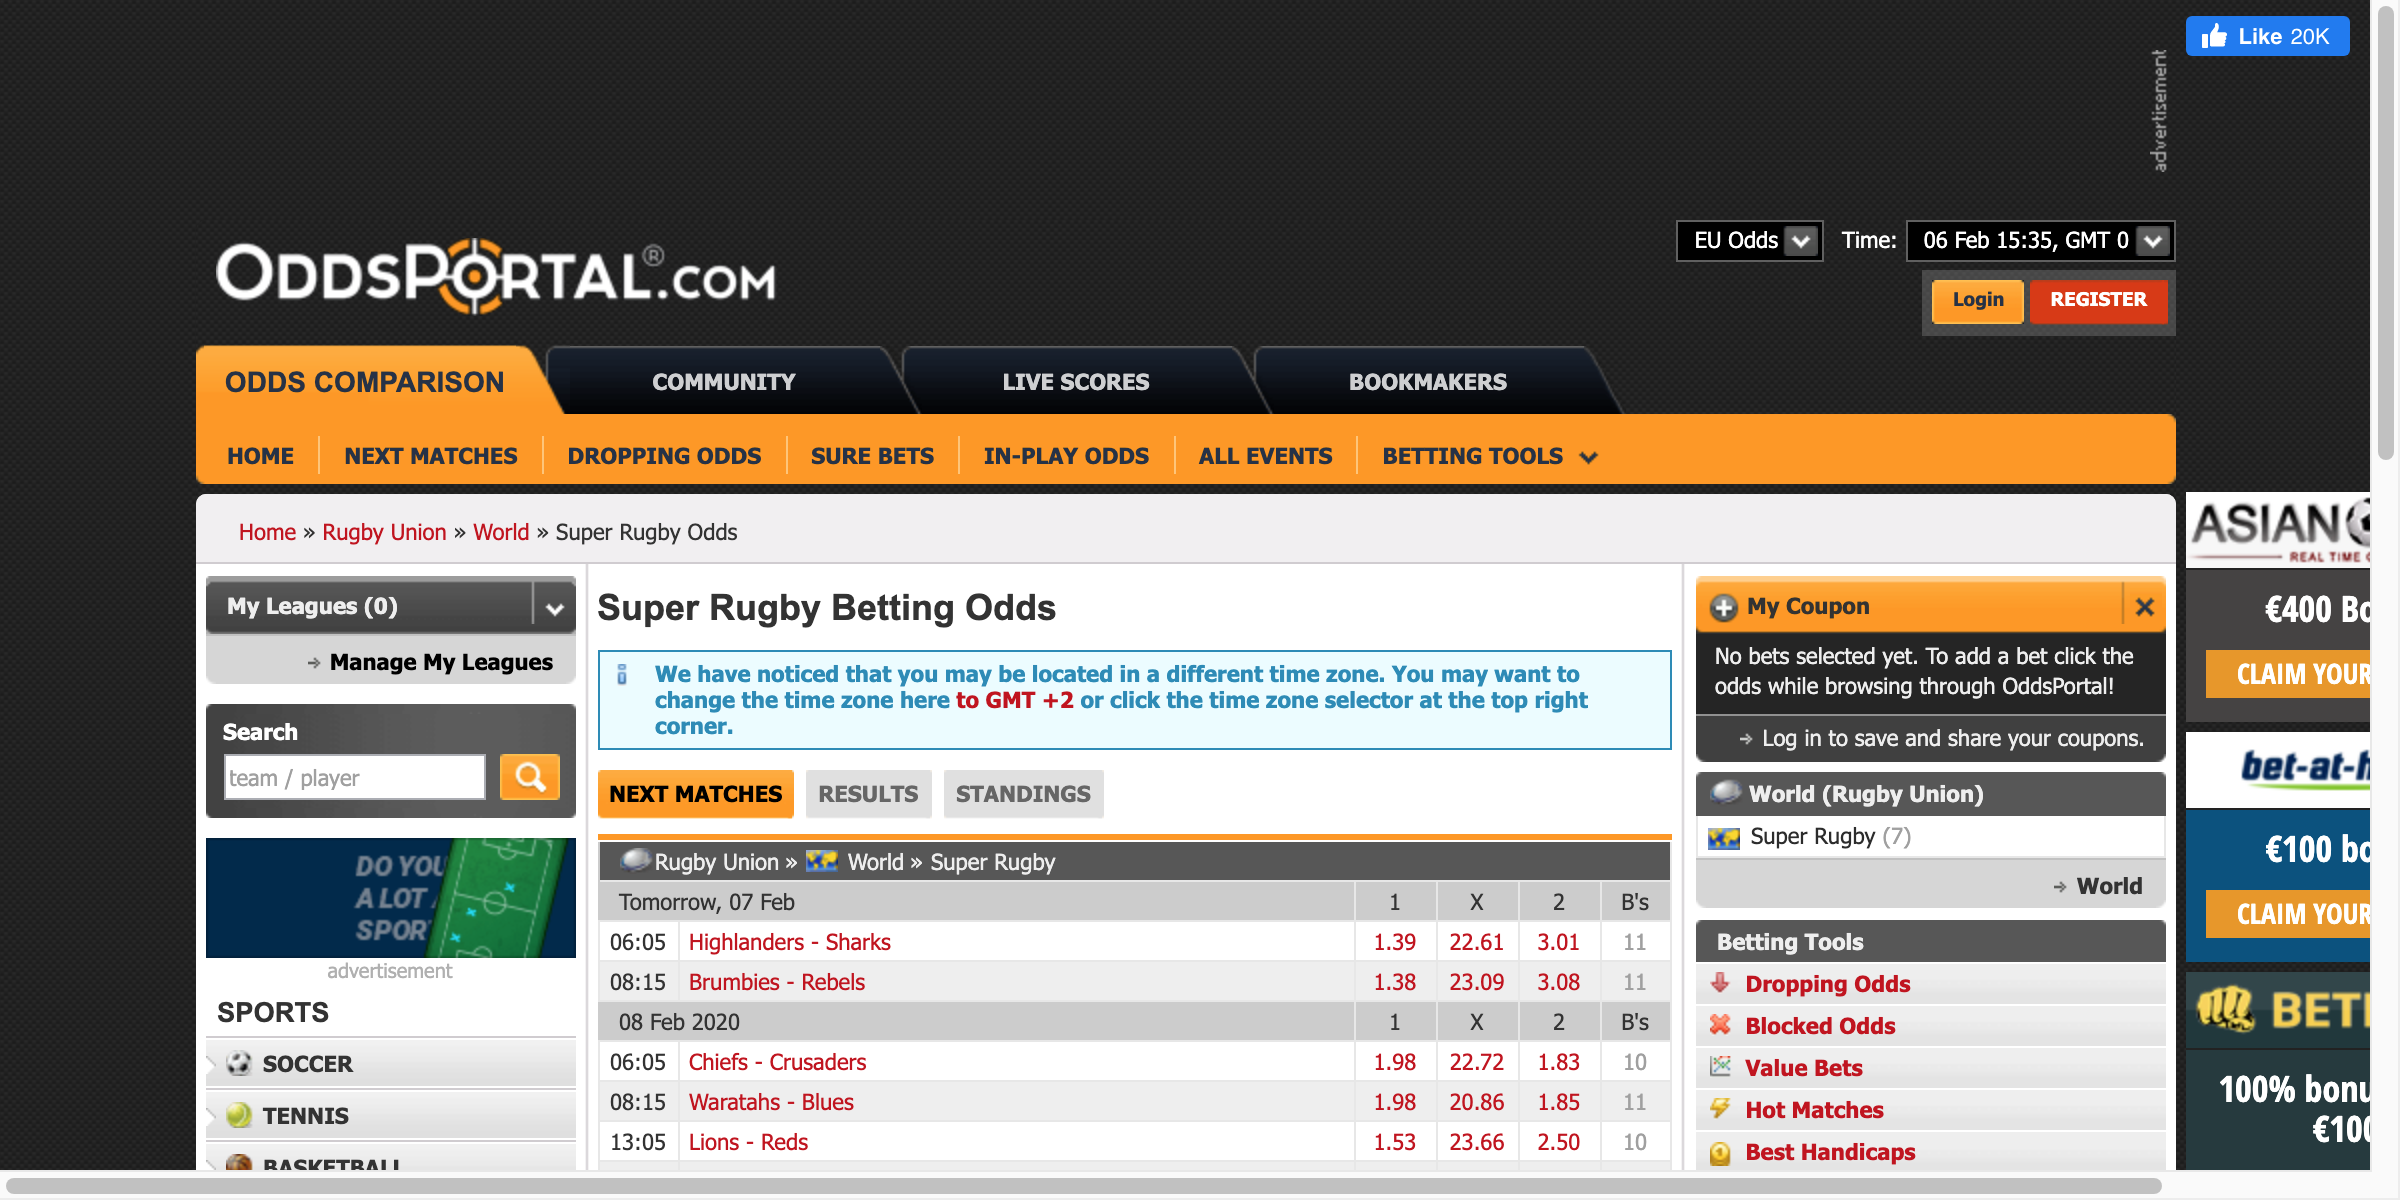

In [7]:
display(
    Image(
        driver.get_screenshot_as_png(),
        width=800,
        height=400
    )
)

In [8]:
table = driver.find_element_by_xpath('//*[@id="tournamentTable"]')

In [9]:
table.find_elements_by_xpath('//*[@id="tournamentTable"]/tbody/tr[7]')

[<selenium.webdriver.remote.webelement.WebElement (session="13588e3a99fb40603035ac4ea8fe0aab", element="3f0ad421-540b-4062-9987-92a0a2a0aaff")>]

In [10]:
table.text

"Rugby Union\n»\n World\n»\nSuper Rugby\nTomorrow, 07 Feb 1 X 2 B's\n06:05 Highlanders - Sharks\n1.39\n22.61\n3.01\n11\n08:15 Brumbies - Rebels\n1.38\n23.09\n3.08\n11\n08 Feb 2020 1 X 2 B's\n06:05 Chiefs - Crusaders\n1.98\n22.72\n1.83\n10\n08:15 Waratahs - Blues\n1.98\n20.86\n1.85\n11\n13:05 Lions - Reds\n1.53\n23.66\n2.50\n10\n15:15 Stormers - Bulls\n1.27\n25.80\n3.74\n10\n23:00 Jaguares - Hurricanes\n1.47\n21.88\n2.75\n10"

In [11]:
table_rows = table.text.split('\n')
table_rows[:25]

['Rugby Union',
 '»',
 ' World',
 '»',
 'Super Rugby',
 "Tomorrow, 07 Feb 1 X 2 B's",
 '06:05 Highlanders - Sharks',
 '1.39',
 '22.61',
 '3.01',
 '11',
 '08:15 Brumbies - Rebels',
 '1.38',
 '23.09',
 '3.08',
 '11',
 "08 Feb 2020 1 X 2 B's",
 '06:05 Chiefs - Crusaders',
 '1.98',
 '22.72',
 '1.83',
 '10',
 '08:15 Waratahs - Blues',
 '1.98',
 '20.86']

In [12]:
# remove table header (first 5 lines)
table_rows = table_rows[5:]

In [13]:
# split list up by dates
date_idx = []
idx = 0
for row in table_rows:
    if "1 X 2 B's" in row:
        print(row)
        date_idx.append(idx)
    idx += 1

Tomorrow, 07 Feb 1 X 2 B's
08 Feb 2020 1 X 2 B's


In [14]:
date_idx

[0, 11]

In [18]:
# schema of dataframe
df = {
    'Date': [],
    'Home Team': [],
    'Away Team': [],
    'Home Score': [],
    'Away Score': [],
    'Play-off Game?': [],
    'Home Odds': [],
    'Draw Odds': [],
    'Away Odds': [],
    'Bookmakers Surveyed': []
}

# for each separate date
for i in range(len(date_idx)):
    
    # extract date
    date = table_rows[date_idx[i]]
    date = date.replace(" 1 X 2 B's", '')
    
    # remove unnecessary text
    if 'Tomorrow' in date or 'Today' in date:
        date = date[date.find(',')+2: ] + ' ' + str(datetime.datetime.now().year)
        
    date = date.replace(' ', '-')
    
    first_match = date_idx[i]+1
    
    fixtures = []
    
    if i < len(date_idx)-1:
        last_match = date_idx[i+1]
        fixtures = table_rows[first_match:last_match]
        
    else:
        fixtures = table_rows[first_match:]
        
    fixtures = np.array(fixtures).reshape(-1, 5)
    date_col = np.repeat([date], fixtures.shape[0])
    fixtures = np.hstack((date_col.reshape(-1, 1), fixtures))
    
    # add each row to dictionary
    for f in fixtures:
        df['Date'].append(f[0])
        df['Home Team'].append(f[1])
        df['Away Team'].append(f[1])
        df['Home Score'].append(0)
        df['Away Score'].append(0)
        df['Play-off Game?'].append('N')
        df['Home Odds'].append(f[2])
        df['Draw Odds'].append(f[3])
        df['Away Odds'].append(f[4])
        df['Bookmakers Surveyed'].append(f[-1])

# convert dictionary to dataframe
df = pd.DataFrame(df)
df.head(7)

,Date,Home Team,Away Team,Home Score,Away Score,Play-off Game?,Home Odds,Draw Odds,Away Odds,Bookmakers Surveyed
0,07-Feb-2020,06:05 Highlanders - Sharks,06:05 Highlanders - Sharks,0,0,N,1.39,22.61,3.01,11
1,07-Feb-2020,08:15 Brumbies - Rebels,08:15 Brumbies - Rebels,0,0,N,1.38,23.09,3.08,11
2,08-Feb-2020,06:05 Chiefs - Crusaders,06:05 Chiefs - Crusaders,0,0,N,1.98,22.72,1.83,10
3,08-Feb-2020,08:15 Waratahs - Blues,08:15 Waratahs - Blues,0,0,N,1.98,20.86,1.85,11
4,08-Feb-2020,13:05 Lions - Reds,13:05 Lions - Reds,0,0,N,1.53,23.66,2.50,10
5,08-Feb-2020,15:15 Stormers - Bulls,15:15 Stormers - Bulls,0,0,N,1.27,25.80,3.74,10
6,08-Feb-2020,23:00 Jaguares - Hurricanes,23:00 Jaguares - Hurricanes,0,0,N,1.47,21.88,2.75,10


In [19]:
def get_home(s):
    '''find the text between the kick-off time and the dash'''
    return re.search(r'[0-2][0-9]:[0-6][0-9](.*?)-', s).group(1).strip()

def get_away(s):
    '''find the last word of text'''
    return s.split()[-1]

print(get_home('06:05 Blues - Chiefs'))
print(get_away('06:05 Blues - Chiefs'))

Blues
Chiefs


In [20]:
df['Home Team'] = df['Home Team'].apply(get_home)
df['Away Team'] = df['Away Team'].apply(get_away)

df.head(7)

,Date,Home Team,Away Team,Home Score,Away Score,Play-off Game?,Home Odds,Draw Odds,Away Odds,Bookmakers Surveyed
0,07-Feb-2020,Highlanders,Sharks,0,0,N,1.39,22.61,3.01,11
1,07-Feb-2020,Brumbies,Rebels,0,0,N,1.38,23.09,3.08,11
2,08-Feb-2020,Chiefs,Crusaders,0,0,N,1.98,22.72,1.83,10
3,08-Feb-2020,Waratahs,Blues,0,0,N,1.98,20.86,1.85,11
4,08-Feb-2020,Lions,Reds,0,0,N,1.53,23.66,2.50,10
5,08-Feb-2020,Stormers,Bulls,0,0,N,1.27,25.80,3.74,10
6,08-Feb-2020,Jaguares,Hurricanes,0,0,N,1.47,21.88,2.75,10


In [21]:
df.to_csv("upcoming_week.csv")